# 타이타닉 생존자 예측
- 반응변수가 연속형인 경우(bike-sharing, boston-housing set)
    - 예측 모델
- 반응변수가 범주형인 경우
    - 분류 모델 

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 통계적 모형
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 머신러닝
from sklearn import datasets
from sklearn import metrics

from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

In [2]:
titanic_raw_data = pd.read_csv('./data/titanic_full_data.csv')

In [3]:
titanic_raw_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1280,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1281,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1282,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1283,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [4]:
titanic_raw_data.set_index(['PassengerId'], inplace=True)

In [5]:
titanic_target = titanic_raw_data[['Survived']]

In [6]:
columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [7]:
titanic_features = titanic_raw_data[columns]

In [8]:
titanic_features

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
1305,3,male,NaN,0,0,8.0500,S
1306,1,female,39.0,0,0,108.9000,C
1307,3,male,38.5,0,0,7.2500,S


# 1. 전처리

## 1. 범주형 변수를 연속형 변수로 변환

In [11]:
titanic_features[['female', 'male']] = pd.get_dummies(titanic_features['Sex'])

In [13]:
titanic_features.drop(columns=['Sex'], inplace=True)

In [15]:
dummy_columns = pd.get_dummies(titanic_features['Embarked']).columns

In [16]:
titanic_features[dummy_columns] = pd.get_dummies(titanic_features['Embarked'])

In [18]:
titanic_features.drop(columns=['Embarked'], inplace=True)

## 2. 연속형 변수를 범주형으로 변환

### 결측치가 있기 때문에, 우선 처리
- 전체 나이의 평균으로 대체

In [21]:
titanic_features['Age'].isna().sum()

255

In [22]:
titanic_features.Age.fillna(round(titanic_features.Age.mean()), inplace=True)

In [23]:
titanic_features['Age'].isna().sum()

0

In [28]:
labels = ['kids', '10s', '20s', '30s', '40s', '50s', '60s', 'others']
bins=[0, 10, 20, 30, 40, 50, 60, 70, 80]

titanic_features['Age2'] = pd.cut(titanic_features['Age'], bins=bins, labels=labels)

In [34]:
age_column = pd.get_dummies(titanic_features['Age2']).columns
titanic_features[age_column] = pd.get_dummies(titanic_features['Age2'])

In [36]:
titanic_features.drop(columns=['Age', 'Age2'], inplace=True)

In [39]:
titanic_features.loc[titanic_features.Fare.isna()]

,Pclass,SibSp,Parch,Fare,female,male,C,Q,S,kids,10s,20s,30s,40s,50s,60s,others
PassengerId,,,,,,,,,,,,,,,,,
1044,3,0,0,NaN,0,1,0,0,1,0,0,0,0,0,0,1,0


In [40]:
titanic_features.loc[titanic_features.Pclass == 3]['Fare'].median()

8.05

In [43]:
titanic_features.Fare.fillna(round(titanic_features.loc[titanic_features.Pclass == 3]['Fare'].median(),4), inplace=True)

In [44]:
titanic_features.isna().sum()

Pclass    0
SibSp     0
Parch     0
Fare      0
female    0
male      0
C         0
Q         0
S         0
kids      0
10s       0
20s       0
30s       0
40s       0
50s       0
60s       0
others    0
dtype: int64

# 2. 로지스틱 회귀 모형

In [45]:
train_x, test_x, train_y, test_y = train_test_split(titanic_features, titanic_target, train_size=0.8, random_state=1234)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1028, 17) (257, 17) (1028, 1) (257, 1)


In [48]:
model = LogisticRegression().fit(train_x, train_y)

In [49]:
pd.concat( [pd.DataFrame(model.coef_.T, columns=['coef']), pd.DataFrame(train_x.columns, columns=['Features'])], axis=1 )

,coef,Features
0,-0.894521,Pclass
1,-0.317775,SibSp
2,-0.069639,Parch
3,0.001637,Fare
4,1.728884,female
5,-0.811613,male
6,0.521332,C
7,0.253598,Q
8,0.114084,S
9,1.369322,kids


## 1. 예측 정확도

In [51]:
pred_y = model.predict(test_x)

In [52]:
pd.concat( [pd.DataFrame(test_y.values, columns=['Y']), pd.DataFrame(pred_y, columns=['Yhat'])], axis=1)

,Y,Yhat
0,1,1
1,1,1
2,0,0
3,0,0
4,0,1
...,...,...
252,0,0
253,0,0
254,1,1
255,1,1


## 2. confusion matrix

| - | true($\hat Y$) | false($\hat Y$) |
|:---:|:---:|:---:|
| true($Y$) | TP | TN |
| false($Y$) | FN | FP |

1. Accuracy
$$
    \frac{tp + fp}{tp + tn + fp + fn}
$$
> 데이터의 불균형이 심한 경우에는 정확한 지표로 삼기 어렵다.   
> TP의 갯수가 압도적으로 많은 경우 FP의 오분류가 많은 경우에 반영이 안된다. 

2. precision(정밀도)
$$
    \frac{tp}{tp + fn}
$$

> true로 예측한 것 중에서 실제 true의 비율

3. recall(재현율)

$$
    \frac{tp}{tp + tn}
$$

> 실제 true에서 true로 예측한 비율

4. F-1 score
$$
    f1 = 2 \cdot \frac{precision \cdot recall}{precision\; + \;recall}
$$

> 데이터의 불균형이 심할 때, 모델의 성능을 정확하게 표현이 가능

In [60]:
test_y['Survived'].value_counts()

0    161
1     96
Name: Survived, dtype: int64

In [53]:
cmat = confusion_matrix(test_y, pred_y)
cmat

array([[136,  25],
       [ 29,  67]])

In [26]:
accuracy = (cmat[0,0] + cmat[1,1])/np.sum(cmat)
accuracy

0.7937743190661478

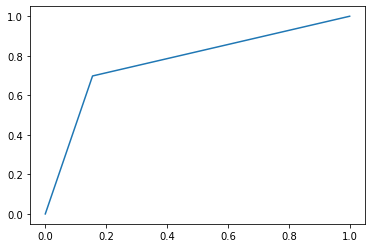

In [61]:
fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y, pos_label=1)
plt.plot(fpr, tpr)
plt.show()

In [30]:
roc_auc_score(test_y, pred_y)

0.7765269151138717